In [9]:
import sys

print(sys.executable)
print(sys.path[:5])

# Importing necessary libraries
# import seaborn as sns

from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import file load.py
from load import discover_runs, read_aggregated_instrument, read_aggregated_routing, RunMeta

/opt/homebrew/anaconda3/envs/router/bin/python
['/Users/paulh/Applications/PyCharm.app/Contents/plugins/python-ce/helpers/jupyter_debug', '/Users/paulh/Applications/PyCharm.app/Contents/plugins/python-ce/helpers/pydev', '/opt/homebrew/anaconda3/envs/router/lib/python314.zip', '/opt/homebrew/anaconda3/envs/router/lib/python3.14', '/opt/homebrew/anaconda3/envs/router/lib/python3.14/lib-dynload']


## Load QSim Instrument Data


Now, let's discover the runs in the output directory and load them.


In [10]:
root = Path("/Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4")

runs = discover_runs(root)
print(runs)

x=4

[RunMeta(run_id='sim128_hor600_w4_r192_10pct', path=PosixPath('/Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/sim128_hor600_w4_r192_10pct'), sim_cpus=128, horizon=600, worker_threads=4, router_threads=192, pct=10), RunMeta(run_id='sim128_hor600_w4_r192_1pct', path=PosixPath('/Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/sim128_hor600_w4_r192_1pct'), sim_cpus=128, horizon=600, worker_threads=4, router_threads=192, pct=1), RunMeta(run_id='sim16_hor600_w4_r192_10pct', path=PosixPath('/Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/sim16_hor600_w4_r192_10pct'), sim_cpus=16, horizon=600, worker_threads=4, router_threads=192, pct=10), RunMeta(run_id='sim16_hor600_w4_r192_1pct', path=PosixPath('/Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/sim16_hor600_w4_r192_1pct'), sim_cpus=16, horizon=600, worker_threads=4, router_threads=192, pct=1), RunMeta(run_id='sim192_hor1800_w4_r192_10pc

In [12]:
qsim_data = {}
for run in runs:
    print(f"Loading run {run.run_id}")
    qsim_data[run.run_id] = read_aggregated_instrument(run)

Loading run sim128_hor600_w4_r192_10pct
Reading parquet:  /Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/sim128_hor600_w4_r192_10pct/instrument/instrument_aggregated.parquet
Loading run sim128_hor600_w4_r192_1pct
Reading parquet:  /Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/sim128_hor600_w4_r192_1pct/instrument/instrument_aggregated.parquet
Loading run sim16_hor600_w4_r192_10pct
Reading parquet:  /Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/sim16_hor600_w4_r192_10pct/instrument/instrument_aggregated.parquet
Loading run sim16_hor600_w4_r192_1pct
Reading parquet:  /Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/sim16_hor600_w4_r192_1pct/instrument/instrument_aggregated.parquet
Loading run sim192_hor1800_w4_r192_10pct
Reading parquet:  /Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/sim192_hor1800_w4_r192_10pct/instrument/instrument_aggregated.parq

Extract some example run data from a dataset to validate the loading process.


In [13]:
# use data from run "sim8_hor600_w4_r192_1pct". Filter for func_name=run
example_run_id = "sim8_hor600_w4_r192_1pct"
example_data = qsim_data[example_run_id]
example_data_run = example_data[example_data["func_name"] == "run"]
print(example_data_run.head())

del example_data, example_data_run

                          run_id  sim_cpus  horizon  worker_threads  \
30247   sim8_hor600_w4_r192_1pct         8      600               4   
60495   sim8_hor600_w4_r192_1pct         8      600               4   
90743   sim8_hor600_w4_r192_1pct         8      600               4   
120991  sim8_hor600_w4_r192_1pct         8      600               4   
151239  sim8_hor600_w4_r192_1pct         8      600               4   

        router_threads  pct  process_id                             target  \
30247              192    1           0  rust_qsim::simulation::simulation   
60495              192    1           1  rust_qsim::simulation::simulation   
90743              192    1           2  rust_qsim::simulation::simulation   
120991             192    1           3  rust_qsim::simulation::simulation   
151239             192    1           4  rust_qsim::simulation::simulation   

       func_name  bin  bin_start  bin_end  duration_min_ns  duration_max_ns  \
30247        run   -1    

Prepare data for the main plot: RTR vs. Number of CPUs by Percentage

In [14]:
# for all data, filter for func_name="run", group by run_id, take mean from duration_min_ns and add as "duration_ns" column, remain with sim_cpus, horizon, worker_threads, router_threads, pct
all_runs_data = pd.concat(qsim_data.values())
all_runs_data_run = all_runs_data[all_runs_data["func_name"] == "run"]
all_runs_grouped = all_runs_data_run.groupby("run_id").agg({"duration_min_ns": "mean"}).reset_index()
all_runs_grouped = all_runs_grouped.merge(
    all_runs_data_run[["run_id", "sim_cpus", "horizon", "worker_threads", "router_threads", "pct"]].drop_duplicates(),
    on="run_id",
)
all_runs_grouped = all_runs_grouped.rename(columns={"duration_min_ns": "duration_ns"})

# Add a new column "rtr"
all_runs_grouped["rtr"] = (60 * 60 * 36 * 1e9) / all_runs_grouped["duration_ns"]

print(all_runs_grouped.head())

                         run_id   duration_ns  sim_cpus  horizon  \
0   sim128_hor600_w4_r192_10pct  1.496146e+11       128      600   
1    sim128_hor600_w4_r192_1pct  3.256682e+10       128      600   
2    sim16_hor600_w4_r192_10pct  1.743025e+11        16      600   
3     sim16_hor600_w4_r192_1pct  2.111672e+10        16      600   
4  sim192_hor1800_w4_r192_10pct  1.415723e+11       192     1800   

   worker_threads  router_threads  pct          rtr  
0               4             192   10   866.225796  
1               4             192    1  3979.510874  
2               4             192   10   743.534774  
3               4             192    1  6137.315443  
4               4             192   10   915.433502  


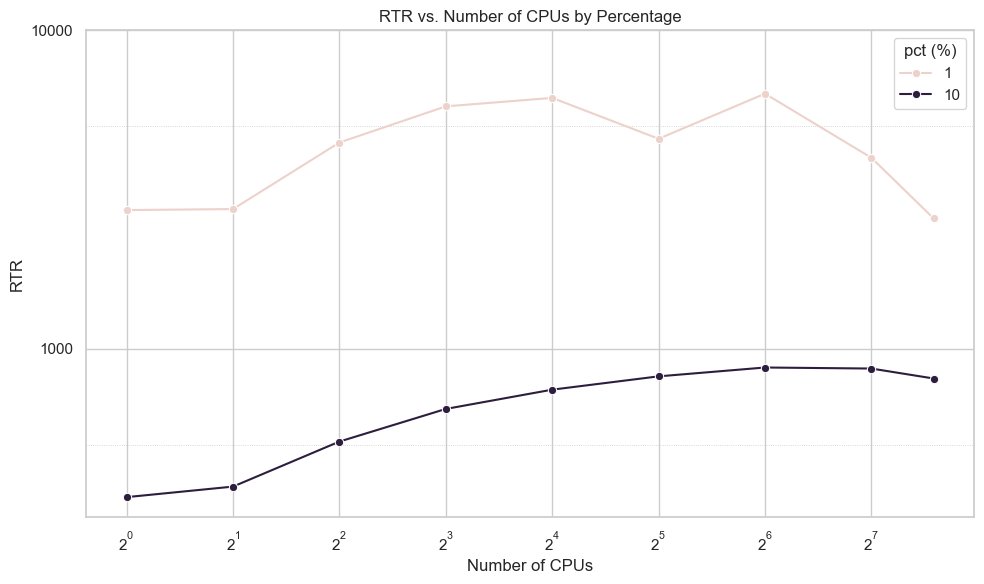

In [15]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.lineplot(
    # filter all_runs_grouped for horizon=600, worker_threads=4, router_threads=192
    data=all_runs_grouped[
        (all_runs_grouped["horizon"] == 600) &
        (all_runs_grouped["worker_threads"] == 4) &
        (all_runs_grouped["router_threads"] == 192)
        ],
    x="sim_cpus",
    y="rtr",
    hue="pct",
    marker="o"
)

plt.title("RTR vs. Number of CPUs by Percentage")
plt.xlabel("Number of CPUs")
plt.ylabel("RTR")

# Log scales
plt.yscale("log", base=10)
plt.xscale("log", base=2)

ax = plt.gca()

from matplotlib.ticker import LogLocator, LogFormatter

ax.yaxis.set_major_locator(LogLocator(base=10.0))
ax.yaxis.set_major_formatter(LogFormatter(base=10))

ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=(0.5,)))

ax.grid(True, which="major", linewidth=1.0)
ax.grid(True, which="minor", linestyle=":", linewidth=0.6)

ax.set_ylim(top=10_000)

plt.legend(title="pct (%)")
plt.tight_layout()
plt.show()

Now, let's plot the stacked bar chart for phases.

In [17]:
# print all unique func_names
print(all_runs_data["func_name"].unique())

# filter all runs data for func_name in ['move_links','move_nodes','notify_end_all', 'notify_wakeup_all']
phases_of_interest = ['move_links', 'move_nodes', 'notify_end_all', 'notify_wakeup_all', 'send_recv']
phases_data = all_runs_data[all_runs_data["func_name"].isin(phases_of_interest)]

# group by run_id and func_name. take mean of duration_mean_ns. Stick with horizon, worker_threads, router_threads, pct
phases_grouped = phases_data.groupby(["run_id", "func_name"]).agg({"duration_mean_ns": "mean"}).reset_index()
phases_grouped = phases_grouped.merge(
    phases_data[["run_id", "sim_cpus", "horizon", "worker_threads", "router_threads", "pct"]].drop_duplicates(),
    on="run_id",
)
print(phases_grouped.head())

del phases_data

<StringArray>
[          'do_step',    'notify_end_all', 'notify_wakeup_all',
         'send_recv',        'move_links',        'move_nodes',
               'run']
Length: 7, dtype: string
                        run_id          func_name  duration_mean_ns  sim_cpus  \
0  sim128_hor600_w4_r192_10pct         move_links      8.232715e+03       128   
1  sim128_hor600_w4_r192_10pct         move_nodes      1.018355e+04       128   
2  sim128_hor600_w4_r192_10pct     notify_end_all      1.648703e+04       128   
3  sim128_hor600_w4_r192_10pct  notify_wakeup_all      4.307677e+03       128   
4  sim128_hor600_w4_r192_10pct          send_recv      1.037573e+06       128   

   horizon  worker_threads  router_threads  pct  
0      600               4             192   10  
1      600               4             192   10  
2      600               4             192   10  
3      600               4             192   10  
4      600               4             192   10  


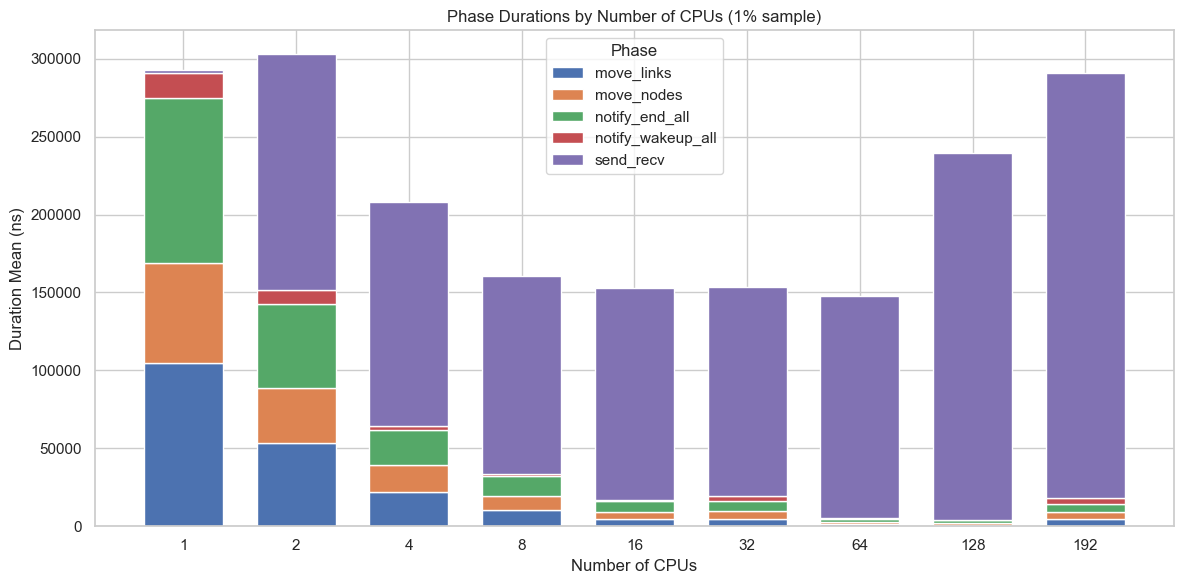

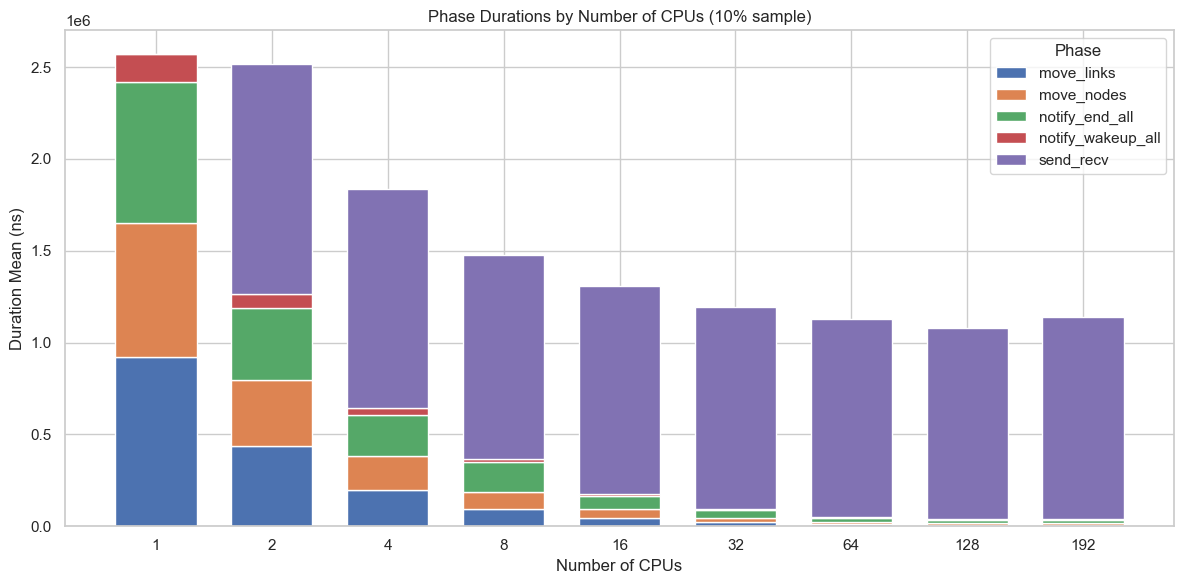

In [18]:
# plot stacked bar chart with sim_cpus on x axis, duration_mean_ns on y axis, hue func_name and stack, facet by pct
import numpy as np
import matplotlib.pyplot as plt

for pct in sorted(phases_grouped["pct"].unique()):

    data = phases_grouped[
        (phases_grouped["pct"] == pct) &
        (phases_grouped["horizon"] == 600) &
        (phases_grouped["worker_threads"] == 4) &
        (phases_grouped["router_threads"] == 192)
    ]

    pivot = (
        data.pivot(
            index="sim_cpus",
            columns="func_name",
            values="duration_mean_ns"
        )
        .sort_index()
    )

    # Treat x as categorical
    x_labels = pivot.index.astype(str)
    x_pos = np.arange(len(pivot))

    plt.figure(figsize=(12, 6))

    bottom = np.zeros(len(pivot))

    for func in pivot.columns:
        plt.bar(
            x_pos,
            pivot[func].values,
            bottom=bottom,
            label=func,
            width=0.7
        )
        bottom += pivot[func].values

    plt.title(f"Phase Durations by Number of CPUs ({pct}% sample)")
    plt.xlabel("Number of CPUs")
    plt.ylabel("Duration Mean (ns)")

    # Categorical x-axis
    plt.xticks(x_pos, x_labels)

    plt.legend(title="Phase")
    plt.tight_layout()
    plt.show()

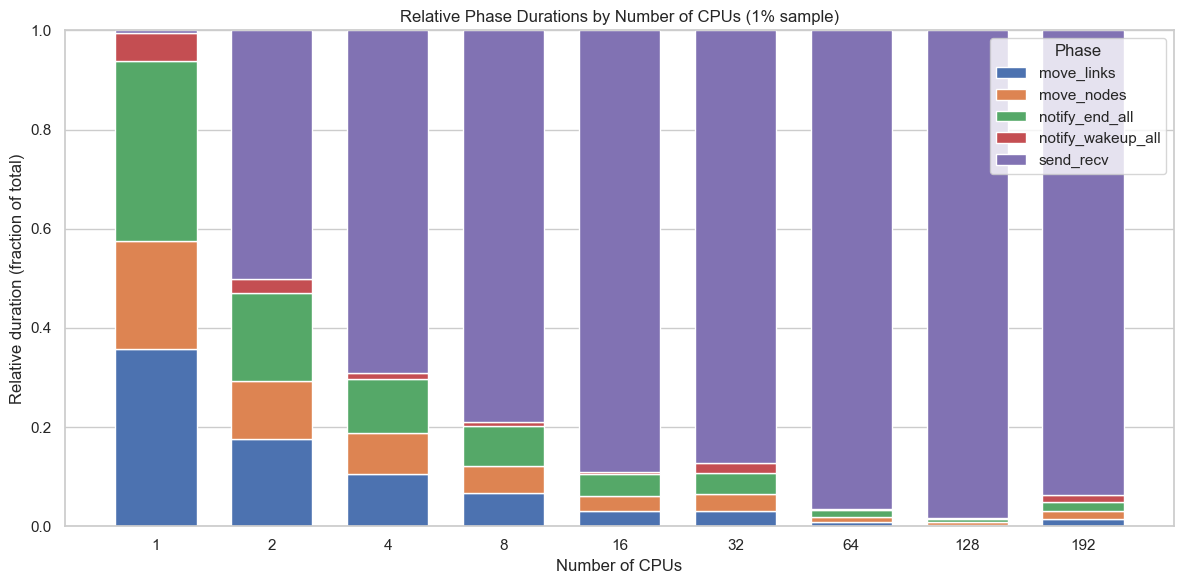

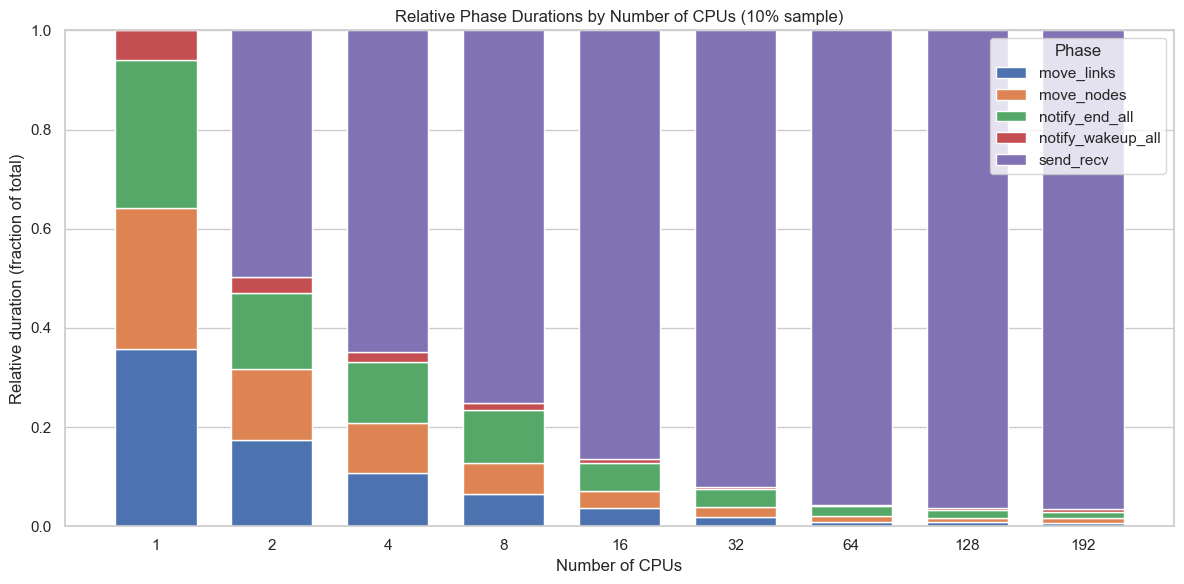

In [19]:
import numpy as np
import matplotlib.pyplot as plt

for pct in sorted(phases_grouped["pct"].unique()):

    data = phases_grouped[
        (phases_grouped["pct"] == pct) &
        (phases_grouped["horizon"] == 600) &
        (phases_grouped["worker_threads"] == 4) &
        (phases_grouped["router_threads"] == 192)
    ]

    pivot = (
        data.pivot(
            index="sim_cpus",
            columns="func_name",
            values="duration_mean_ns"
        )
        .sort_index()
    )

    # Normalize each row so the stacked bar sums to 1.0
    row_sums = pivot.sum(axis=1)
    pivot_rel = pivot.div(row_sums, axis=0).fillna(0.0)

    # Treat x as categorical
    x_labels = pivot_rel.index.astype(str)
    x_pos = np.arange(len(pivot_rel))

    plt.figure(figsize=(12, 6))

    bottom = np.zeros(len(pivot_rel))

    for func in pivot_rel.columns:
        vals = pivot_rel[func].values
        plt.bar(
            x_pos,
            vals,
            bottom=bottom,
            label=func,
            width=0.7
        )
        bottom += vals

    plt.title(f"Relative Phase Durations by Number of CPUs ({pct}% sample)")
    plt.xlabel("Number of CPUs")
    plt.ylabel("Relative duration (fraction of total)")

    plt.xticks(x_pos, x_labels)
    plt.ylim(0, 1)  # because proportions

    plt.legend(title="Phase")
    plt.tight_layout()
    plt.show()

In [24]:
# cleanup irrelevant variables
del all_runs_data, qsim_data # currently 25GB!

## Loading Routing Data

In [22]:
routing_data: dict[str, pd.DataFrame] = {}

for run in runs:
    print(f"Loading routing data for run {run.run_id}")
    routing_data[run.run_id] = read_aggregated_routing(run)


Loading routing data for run sim128_hor600_w4_r192_10pct
Reading parquet:  /Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/sim128_hor600_w4_r192_10pct/instrument/routing_aggregated.parquet
Loading routing data for run sim128_hor600_w4_r192_1pct
Reading parquet:  /Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/sim128_hor600_w4_r192_1pct/instrument/routing_aggregated.parquet
Loading routing data for run sim16_hor600_w4_r192_10pct
Reading parquet:  /Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/sim16_hor600_w4_r192_10pct/instrument/routing_aggregated.parquet
Loading routing data for run sim16_hor600_w4_r192_1pct
Reading parquet:  /Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/sim16_hor600_w4_r192_1pct/instrument/routing_aggregated.parquet
Loading routing data for run sim192_hor1800_w4_r192_10pct
Reading parquet:  /Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/outpu

In [25]:
ex_id = "sim4_hor600_w4_r192_10pct"

# group by rank and count number of occurrences of each rank
routing_example = routing_data[ex_id]

print(routing_example.head())
routing_example_grouped = routing_example.groupby("rank").size().reset_index(name="count")
print(routing_example_grouped.head())

del routing_example, routing_example_grouped

                                       target          func_name  duration_ns  \
0  rust_qsim::simulation::agents::agent_logic      replace_route          270   
1  rust_qsim::simulation::agents::agent_logic        call_router        10520   
2  rust_qsim::simulation::agents::agent_logic      blocking_recv      1834040   
3  rust_qsim::simulation::agents::agent_logic  replace_next_trip         2130   
4  rust_qsim::simulation::agents::agent_logic      replace_route      1839210   

   sim_time    person_id mode  rank                     run_id  sim_cpus  \
0      5539  bb_46e2380e          0  sim4_hor600_w4_r192_10pct         4   
1      5748  bb_46e2380e   pt     0  sim4_hor600_w4_r192_10pct         4   
2      5748  bb_46e2380e          0  sim4_hor600_w4_r192_10pct         4   
3      5748  bb_46e2380e          0  sim4_hor600_w4_r192_10pct         4   
4      5748  bb_46e2380e          0  sim4_hor600_w4_r192_10pct         4   

   horizon  worker_threads  router_threads  pct  process

In [27]:
all_routing_data = pd.concat(routing_data.values())

#filter out all replace_route entries where request_uuid_u128=0
all_routing_data = all_routing_data[
    ~((all_routing_data["func_name"] == "replace_route") & (all_routing_data["request_uuid_u128"] == 0))]

print(all_routing_data.head())

all_routing_data = all_routing_data[all_routing_data["func_name"] == "replace_route"]

In [51]:
# filter all_routing_data for pct=10 and func_name="replace_route". group by run_id and process_id, preserve sim_cpus,horizon,worker_threads,router_threads,pct. Sum duration_ns.
routing_filtered = all_routing_data[all_routing_data["func_name"] == "replace_route"]
routing_grouped = routing_filtered.groupby(["run_id", "process_id"]).agg({"duration_ns": "sum"}).reset_index()
routing_grouped = routing_grouped.merge(
    routing_filtered[["run_id", "sim_cpus", "horizon", "worker_threads", "router_threads", "pct"]].drop_duplicates(),
    on="run_id",
)
print(routing_grouped.head())

# join all_runs_data_run and routing_grouped on run_id and process_id to get total duration_ns
merged_routing = routing_grouped.merge(
    all_runs_data_run[["run_id", "process_id", "duration_min_ns"]],
    on=["run_id", "process_id"],
    suffixes=("_routing", "_total")
)
print(merged_routing.head())

del routing_filtered, routing_grouped

                        run_id  process_id  duration_ns  sim_cpus  horizon  \
0  sim128_hor600_w4_r192_10pct           0    357879961       128      600   
1  sim128_hor600_w4_r192_10pct           1    686078827       128      600   
2  sim128_hor600_w4_r192_10pct           2     41393866       128      600   
3  sim128_hor600_w4_r192_10pct           3    214992719       128      600   
4  sim128_hor600_w4_r192_10pct           4    881043148       128      600   

   worker_threads  router_threads  pct  
0               4             192   10  
1               4             192   10  
2               4             192   10  
3               4             192   10  
4               4             192   10  
                        run_id  process_id  duration_ns  sim_cpus  horizon  \
0  sim128_hor600_w4_r192_10pct           0    357879961       128      600   
1  sim128_hor600_w4_r192_10pct           1    686078827       128      600   
2  sim128_hor600_w4_r192_10pct           2     4139

For each run, choose the process that needed to wait the longest for routing and plot that against the total duration_ns of that process.

                         run_id  process_id  duration_ns  sim_cpus  horizon  \
0   sim128_hor600_w4_r192_10pct          39  11432082278       128      600   
1    sim128_hor600_w4_r192_1pct          92  11589118951       128      600   
2    sim16_hor600_w4_r192_10pct           7  43359130496        16      600   
3     sim16_hor600_w4_r192_1pct           7   3655252845        16      600   
4  sim192_hor1800_w4_r192_10pct          22   9766531463       192     1800   

   worker_threads  router_threads  pct  duration_min_ns  
0               4             192   10     149614350474  
1               4             192    1      32566637669  
2               4             192   10     174302547626  
3               4             192    1      21116728727  
4               4             192   10     141573224392  


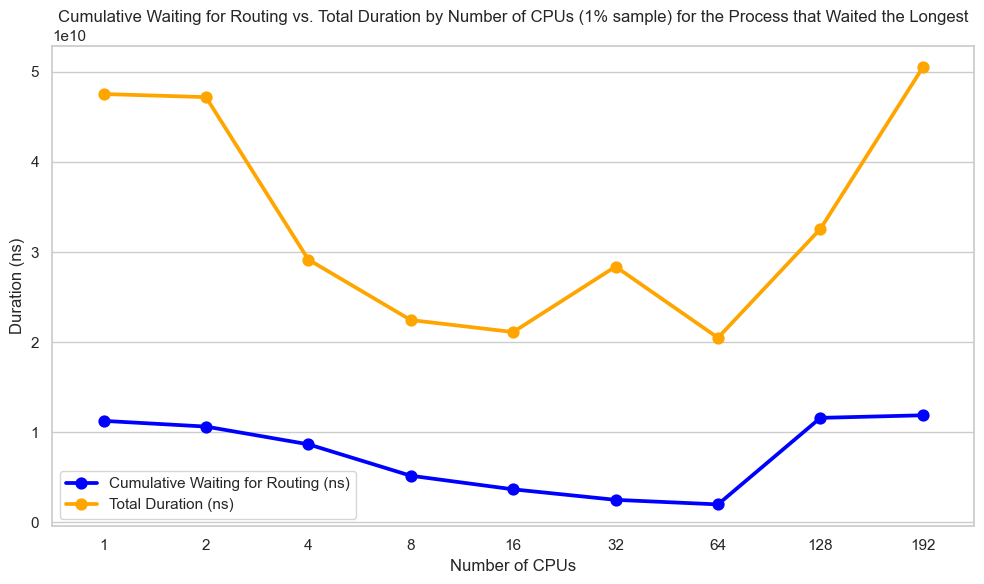

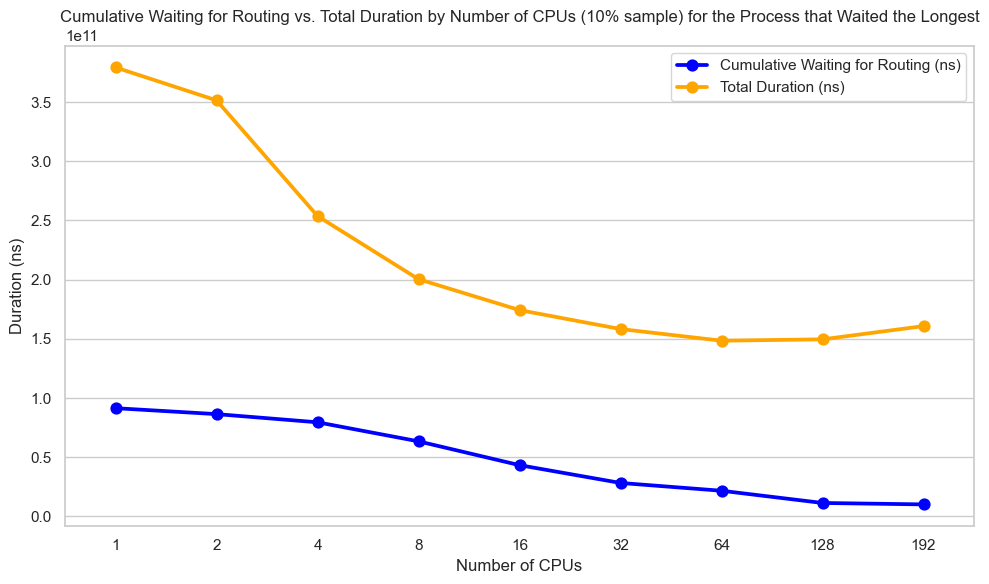

In [52]:
# plot bar chart. filter for pct=10. group by run_id, take max of duration_ns and duration_min_ns of the corresponding entry. Plot sim_cpus on x axis, duration_ns and duration_min_ns on y axis next to each other as bars. use seaborn
idx = merged_routing.groupby("run_id")["duration_ns"].idxmax()
max_routing_recv = merged_routing.loc[idx].reset_index(drop=True)
print(max_routing_recv.head())

for p in sorted(max_routing_recv["pct"].unique()):
    pct_ = max_routing_recv[
        (max_routing_recv["pct"] == p) &
        (max_routing_recv["horizon"] == 600) &
        (max_routing_recv["worker_threads"] == 4) &
        (max_routing_recv["router_threads"] == 192)
    ]

    plt.figure(figsize=(10, 6))
    sns.pointplot(data=pct_,
                  x="sim_cpus",
                  y="duration_ns",
                  color="blue",
                  label="Cumulative Waiting for Routing (ns)",
                  marker="o")
    sns.pointplot(data=pct_,
                  x="sim_cpus",
                  y="duration_min_ns",
                  color="orange",
                  label="Total Duration (ns)",
                  marker="o")

    plt.title(f"Cumulative Waiting for Routing vs. Total Duration by Number of CPUs ({p}% sample) for the Process that Waited the Longest")
    plt.xlabel("Number of CPUs")
    plt.ylabel("Duration (ns)")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [57]:
# group by run_id, sum duration_ns, stick with sim_cpus, horizon, worker_threads, router_threads, pct
total_routing_wait = merged_routing.groupby("run_id").agg({"duration_ns": "sum", "duration_min_ns": "sum"}).reset_index()
total_routing_wait = total_routing_wait.merge(
    merged_routing[["run_id", "sim_cpus", "horizon", "worker_threads", "router_threads", "pct"]].drop_duplicates(),
    on="run_id",
)


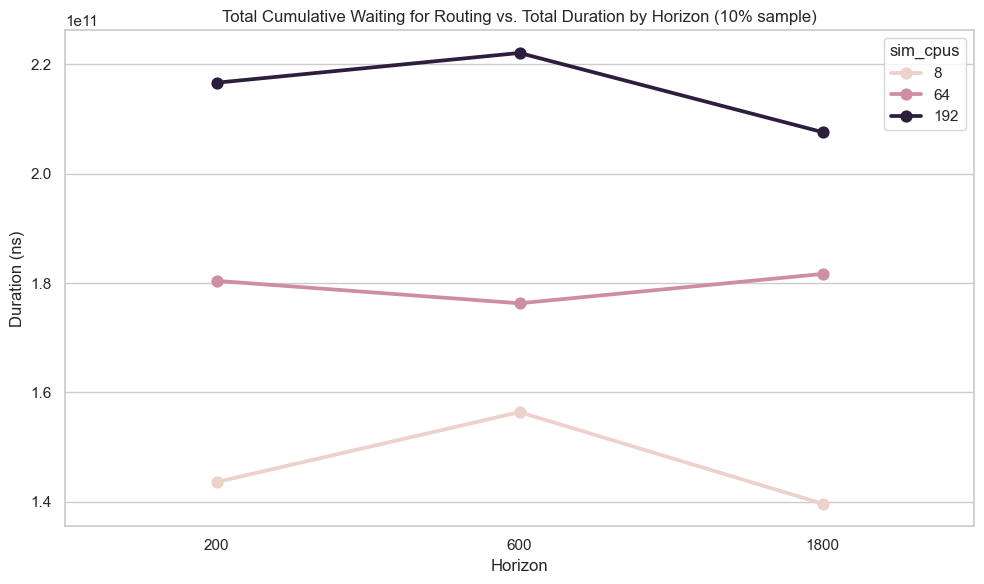

In [58]:
# filter for sim_cpus in [8,64,192], worker_threads=4, router_threads=192
filtered_total_routing_wait = total_routing_wait[
    (total_routing_wait["sim_cpus"].isin([8, 64, 192])) &
    (total_routing_wait["worker_threads"] == 4) &
    (total_routing_wait["router_threads"] == 192) &
    (total_routing_wait["pct"] == 10)
]

# create point plot with horizon on x axis and duration_ns and duration_min_ns on y axis
# hue for horizon
plt.figure(figsize=(10, 6))
sns.pointplot(data=filtered_total_routing_wait, x="horizon", y="duration_ns", hue="sim_cpus", marker="o")
# sns.pointplot(data=filtered_total_routing_wait, x="sim_cpus", y="duration_min_ns", hue="horizon", marker="x")

plt.title("Total Cumulative Waiting for Routing vs. Total Duration by Horizon (10% sample)")
plt.xlabel("Horizon")
plt.ylabel("Duration (ns)")
plt.tight_layout()
plt.show()

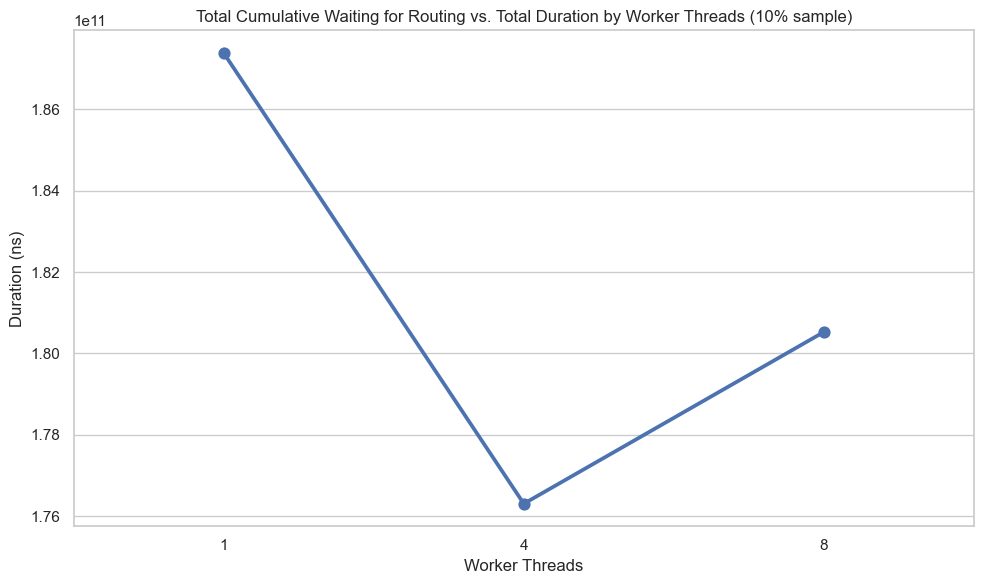

In [61]:
# filter for sim_cpus in [64], horizon=600, router_threads=192
filtered_total_routing_wait = total_routing_wait[
    (total_routing_wait["sim_cpus"].isin([64])) &
    (total_routing_wait["horizon"] == 600) &
    (total_routing_wait["router_threads"] == 192) &
    (total_routing_wait["pct"] == 10)
]

# create point plot with horizon on x axis and duration_ns and duration_min_ns on y axis
# hue for horizon
plt.figure(figsize=(10, 6))
sns.pointplot(data=filtered_total_routing_wait, x="worker_threads", y="duration_ns", marker="o")
# sns.pointplot(data=filtered_total_routing_wait, x="sim_cpus", y="duration_min_ns", hue="horizon", marker="x")

plt.title("Total Cumulative Waiting for Routing vs. Total Duration by Worker Threads (10% sample)")
plt.xlabel("Worker Threads")
plt.ylabel("Duration (ns)")
plt.tight_layout()
plt.show()

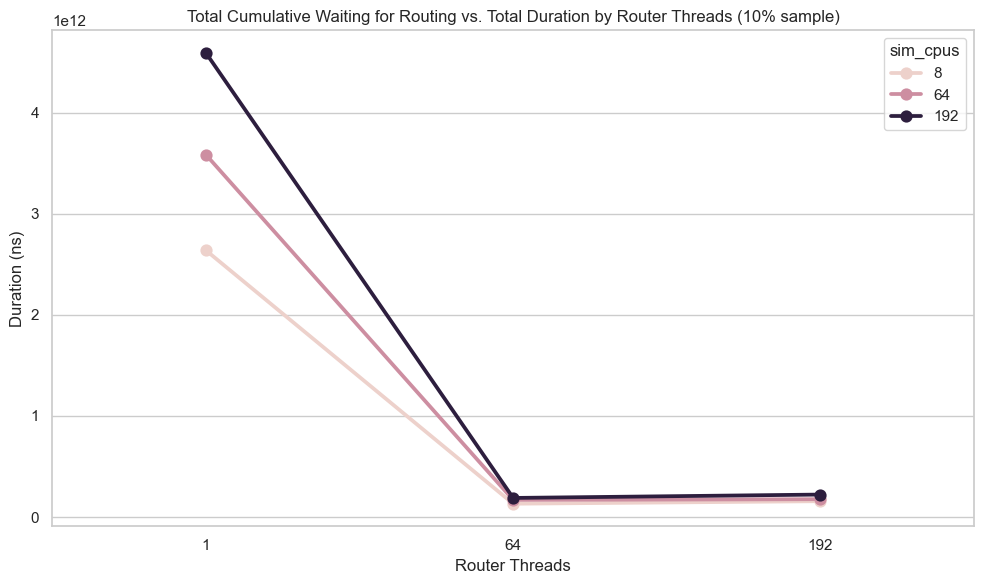

In [64]:
# filter for sim_cpus in [8,64,192], worker_threads=4, router_threads=192
filtered_total_routing_wait = total_routing_wait[
    (total_routing_wait["sim_cpus"].isin([8, 64, 192])) &
    (total_routing_wait["worker_threads"] == 4) &
    (total_routing_wait["horizon"] == 600) &
    (total_routing_wait["pct"] == 10)
]

# create point plot with horizon on x axis and duration_ns and duration_min_ns on y axis
# hue for horizon
plt.figure(figsize=(10, 6))
sns.pointplot(data=filtered_total_routing_wait, x="router_threads", y="duration_ns", hue="sim_cpus", marker="o")
# sns.pointplot(data=filtered_total_routing_wait, x="sim_cpus", y="duration_min_ns", hue="horizon", marker="x")

plt.title("Total Cumulative Waiting for Routing vs. Total Duration by Router Threads (10% sample)")
plt.xlabel("Router Threads")
plt.ylabel("Duration (ns)")
plt.tight_layout()
plt.show()

## Further investigation of routing functions

In [67]:
# in all_routing_data, group by func_name, run_id and process_id, take sum of duration_ns. stick with sim_cpus, horizon, worker_threads, router_threads, pct
routing_sum_func = pd.concat(routing_data.values()).groupby(["func_name", "run_id", "process_id"]).agg({"duration_ns": "sum"}).reset_index()
routing_sum_func = routing_sum_func.merge(
    all_routing_data[["run_id", "sim_cpus", "horizon", "worker_threads", "router_threads", "pct"]].drop_duplicates(),
    on="run_id",
)
print(routing_sum_func.head())

       func_name                       run_id  process_id  duration_ns  \
0  blocking_recv  sim128_hor600_w4_r192_10pct           0    304369285   
1  blocking_recv  sim128_hor600_w4_r192_10pct           1    604707176   
2  blocking_recv  sim128_hor600_w4_r192_10pct           2     35194348   
3  blocking_recv  sim128_hor600_w4_r192_10pct           3    185344781   
4  blocking_recv  sim128_hor600_w4_r192_10pct           4    753631426   

   sim_cpus  horizon  worker_threads  router_threads  pct  
0       128      600               4             192   10  
1       128      600               4             192   10  
2       128      600               4             192   10  
3       128      600               4             192   10  
4       128      600               4             192   10  


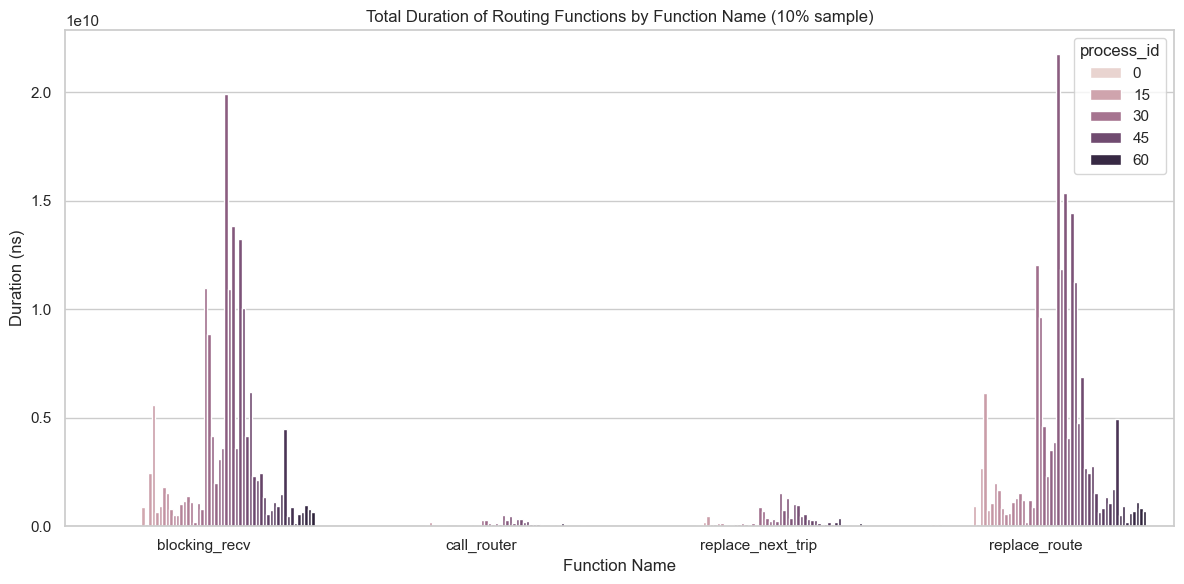

In [73]:
# for the specific run where sim_cpus=64, horizon=600, worker_threads=4, router_threads=192, pct=10, plot a bar chart of func_name vs. duration_ns
specific_routing = routing_sum_func[
    (routing_sum_func["sim_cpus"] == 64) &
    (routing_sum_func["horizon"] == 600) &
    (routing_sum_func["worker_threads"] == 4) &
    (routing_sum_func["router_threads"] == 192) &
    (routing_sum_func["pct"] == 10)
]

plt.figure(figsize=(12, 6))
sns.barplot(data=specific_routing, x="func_name", y="duration_ns", hue="process_id")
plt.title("Total Duration of Routing Functions by Function Name (10% sample)")
plt.xlabel("Function Name")
plt.ylabel("Duration (ns)")
plt.tight_layout()
plt.show()

In [84]:
# compare the duration of blocking_recv vs send_recv for the same specific run

# find the run where runid is specific_run_id
specific_run_id = "sim64_hor600_w4_r192_10pct"
specific_run_meta: RunMeta = next(filter(lambda r: r.run_id == specific_run_id, runs))

specific_instrument = read_aggregated_instrument(specific_run_meta)

Reading parquet:  /Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/sim64_hor600_w4_r192_10pct/instrument/instrument_aggregated.parquet


In [96]:
specific_instrument_send_recv = specific_instrument[specific_instrument["func_name"] == "send_recv"].copy()
specific_instrument_send_recv["duration_send_recv_ns"] = specific_instrument_send_recv["duration_mean_ns"] * (specific_instrument_send_recv["bin_end"] - specific_instrument_send_recv["bin_start"] + 1)
specific_instrument_send_recv = specific_instrument_send_recv.groupby("process_id").agg({"duration_send_recv_ns": "sum"}).reset_index()
specific_routing_blocking_recv = specific_routing[specific_routing["func_name"] == "blocking_recv"]

# merge specific_routing_blocking_recv and specific_instrument_send_recv on process_id, stick with every other column
specific_merged = specific_routing_blocking_recv.merge(specific_instrument_send_recv, on="process_id")
print(specific_merged.head())

       func_name                      run_id  process_id  duration_ns  \
0  blocking_recv  sim64_hor600_w4_r192_10pct          14    863118069   
1  blocking_recv  sim64_hor600_w4_r192_10pct          15     77581855   
2  blocking_recv  sim64_hor600_w4_r192_10pct          16   2463449667   
3  blocking_recv  sim64_hor600_w4_r192_10pct          17   5573982569   
4  blocking_recv  sim64_hor600_w4_r192_10pct          18    631062458   

   sim_cpus  horizon  worker_threads  router_threads  pct  \
0        64      600               4             192   10   
1        64      600               4             192   10   
2        64      600               4             192   10   
3        64      600               4             192   10   
4        64      600               4             192   10   

   duration_send_recv_ns  
0           1.411394e+11  
1           1.449546e+11  
2           1.409822e+11  
3           1.318634e+11  
4           1.437203e+11  


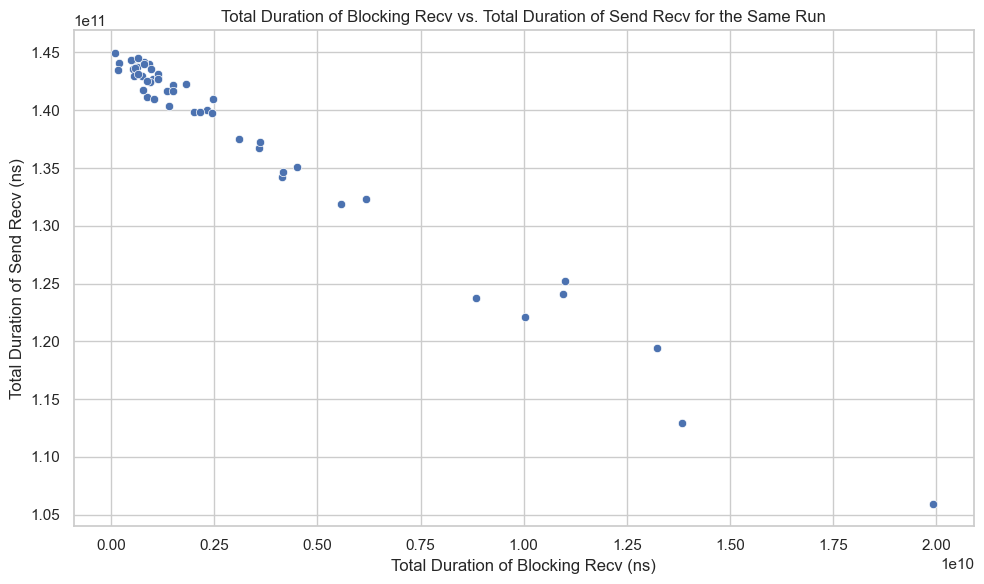

In [98]:
# plot on x axis duration_ns (sum of all blocking_recv calls) and on y the duration_send_recv_ns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=specific_merged, x="duration_ns", y="duration_send_recv_ns")
plt.title("Total Duration (Sum) of Blocking Recv vs. Total Duration (Sum) of Send Recv for the Same Run")
plt.xlabel("Total Duration (Sum) of Blocking Recv (ns)")
plt.ylabel("Total Duration (Sum) of Send Recv (ns)")
plt.tight_layout()
plt.show()

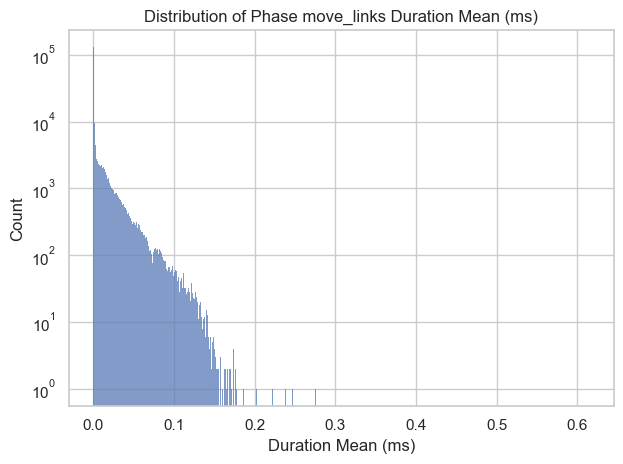

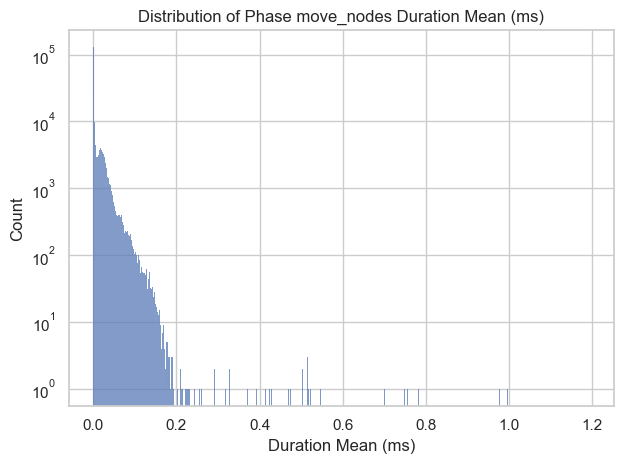

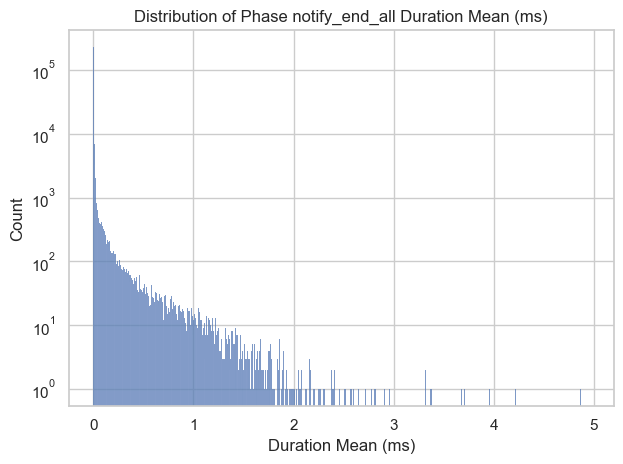

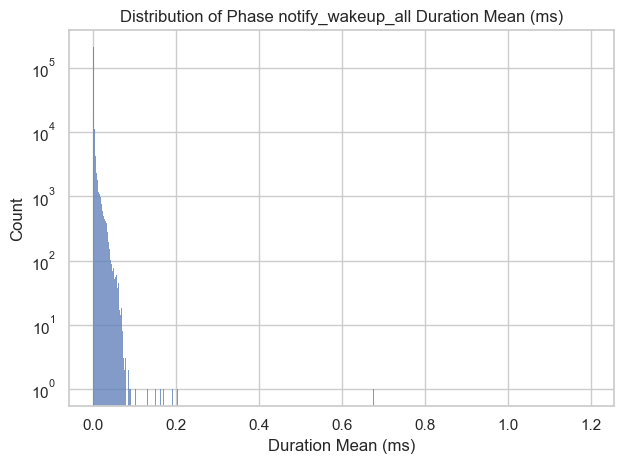

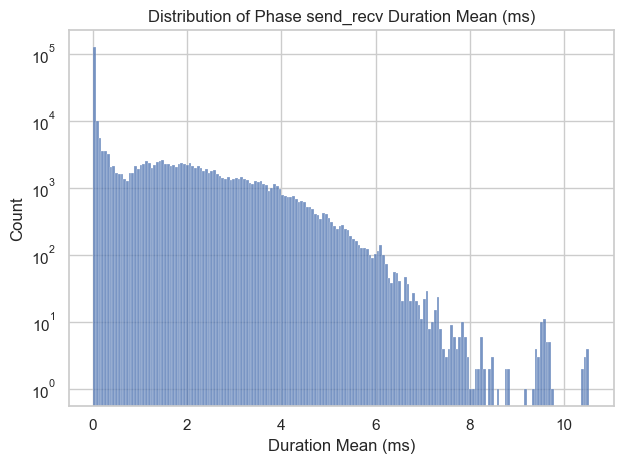

In [118]:
# plot the distribution of duration_ns in specific_instrument[specific_instrument["func_name"] == "send_recv"]
for p in phases_of_interest:
    sns.histplot(specific_instrument[specific_instrument["func_name"] == p]["duration_mean_ns"] / 1e6)
    plt.title(f"Distribution of Phase {p} Duration Mean (ms)")
    plt.xlabel("Duration Mean (ms)")
    plt.yscale("log", base=10)
    plt.tight_layout()
    plt.show()


In [105]:
specific_routing = read_aggregated_routing(specific_run_meta)

Reading parquet:  /Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/sim64_hor600_w4_r192_10pct/instrument/routing_aggregated.parquet


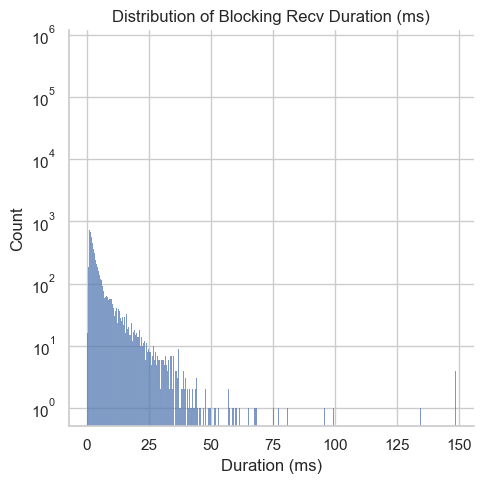

In [113]:
df = specific_routing[specific_routing["func_name"] == "blocking_recv"]

# plot distribution of duration_ns
sns.displot(df["duration_ns"] / 1e6)
plt.yscale("log", base=10)
plt.title("Distribution of Blocking Recv Duration (ms)")
plt.xlabel("Duration (ms)")
plt.tight_layout()
plt.show()